## Full matrix representation - version 2 (WIP)

The full version of the transportation model will allow for any number of patches and any number of connecting corridors between each pair of patches. The state variables will thus be given with matrices. These matrices have to be aggregated and passed to `ODEProblem` (a function of the `DifferentialEquations` package) using the `ArrayPartition` object type. In the future, we would like to try implementing the code with the `ModelingToolkit` package (instead of Differential Equations).

This version should allow for any number of patches and any number of connecting corridors for each pair of patches.

**Current issues**
- Scenario 1 (2 patches, 1 corridor) does not match behavior with XPPAUT
- Unless I set the condition ``isoutofdomain'', I can end up with negative values for populations (specifically from Patch 1)
- I created an `output_log.csv` (in hopes of imitating the "Data" tab of XPPAUT), but it doesn't account for the fact that I multiply the change by `dt`

**Next steps:**
- Convert traffic flows to average speeds and then to emissions (rates and total)
    - Try to model U-shaped curve with something like a (x-40)**4 + 1...

- Once this is fixed
    - Get it working for 2 nodes, 1 through 3 corridors
    - Diurnal
    - Restructure this notebook so that cells are hideable and scenarios are all together (initial conditions, run, plot, all in one cell)

**Notes to self:**
- exp.(C) needed whenever C is a matrix. exp(C) tries to perform the matrix exponential, which is only defined for square matrices
- when indexing a matrix or array, you must provide a value for each dimension. So if `C0` is 3D, `C0[:, 1, :]` will give an output, while `C0[:, 1]` will throw an error
- want a loaf of identity matrices? (one per slice, see?) do this: `eye = cat([I(n) for _ in 1:k]..., dims=3)`. That `...` is the "splat operator" or "spread operator".
- if you want to "transpose" an array (higher dim than a matrix), do something like this `permutedims(A, (2, 1, 3))`

**Diurnal System Plan (how to create a clock)**
- x=sin(theta), y=cos(theta)
- x' = cos(theta) = y, y' = - sin(theta) = -x
- Jacobian is: [[0,1][-1,0]] (diagonals give real part of eigenvalue, off-diagonals give rotation). Trace=0, Determinant=1, eigenvalues = 0 +/- i (exactly a circle, not hyperbolic -- so whatever initial condition you give it, it will stay there)
- Construct a limit cycle. "It's a lot easier to graph a function than it is to function a graph."
- Go to polar coordinates: r' = r(1-r)  (that's a logistic, with a stable point at r=1). x' = r(1-r) + y, y' = r(1-r) -x, where r=sqrt(x^2 + y^2)
- How to make the frequency something like 1 day? (2 pi / p1) where p1 is period 1 (they did a fourier analysis of a time series to get some periods)
- start at x=1 and y=0, make sure it's stable and that you don't get any drift
- 2 variables to generate the oscillation, but then just use one of them (sin(theta) or cos(theta)) for your "time"
- arctan() in order to transform a sin wave to get the shape that you want. Or e^cos() or whatever.
- check how to change the argument of an exponential so that it has a sharp peak

#### Note to self - Jan 29, 2025
- Turns out my conservation law was not violated, I just wasn't plotting everything. (There was also a problem with the order in which I labeled my plots. Should hopefully be fixed now?)
- Added (simpler) scenario 1 for direct comparison with XPPAUT model. Isn't working? I am printing the outputs of each step to a csv file `output_log.csv`, but it isn't the most useful since I don't multiply by the timestep (and the timesteps vary each time). Regardless, I can clearly see that P1 begins with a positive slope, whereas XPPAUT shows that it should start with a negative slope.
- In Scenario 2, see that population of P1 goes negative? Not sure how to fix that. I can use a keyword arg to set the expected domain, but that just stops the evaluation early if it goes negative. How do I prevent it going negative at all?

In [ ]:
# Diurnal
#exp(10*sin(2*pi*9x-3)/24) - 0.3
#exp(10*sin(2*pi*(-x)/24)) - 0.3

In [6]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Roots
using DifferentialEquations
using Interpolations
using RecursiveArrayTools
using QuadGK
using Printf
using CSV
using DataFrames

#### Function for system of equations
- State variables: populations in patches ($P$), populations in corridors ($C$), both passed with argument $N$
- Parameters: passed as an array with argument $p$
- time: argument $t$ gives a times span over which to solve the system

In [7]:
function sys_of_eqs!(dN, N, p, t)
    #=
        Returns (change in place)
            - dN: VectorOfArrays, (P, C)
                    population values at next time step
        Arguments
            - dN: VectorOfArrays, (P, C)
                    population values at next time step
            - N: VectorOfArrays, (P, C)
                    population values at current time step
                    N = [P¹, P², C¹₁₂, C¹₂₁, C²₁₂, C²₂₁]
            - p: VectorOfArrays, size (3, ...)
                    parameters
                    p = [αᵢ, βₖ, pi_out]
    =#
    
    # get variables
    P = N.x[1]     # 1D array with n elements
    C = N.x[2]     # n x n x k array
    C_map = C .!= 0.0 # should this be passed in separately, or can I trust it to recalculate each time?
    n = length(P)  # number of patches
    k = size(C)[3] # number of "layers" of corridors (max number of corridors per pair)

    C1_p1_to_p1=C[1,1,1]; C1_p1_to_p2=C[1,2,1]; C1_p2_to_p1=C[2,1,1]; C1_p2_to_p2=C[2,2,1]
    C2_p1_to_p1=C[1,1,2]; C2_p1_to_p2=C[1,2,2]; C2_p2_to_p1=C[2,1,2]; C2_p2_to_p2=C[2,2,2]
    println("____________")
    println("C1_p1_to_p2:$C1_p1_to_p2")
    println("C1_p2_to_p1:$C1_p2_to_p1")
    println("C2_p1_to_p2:$C2_p1_to_p2")
    println("C2_p2_to_p1:$C2_p2_to_p1")

    # get parameters
    α = p[1] # α[i] is aversion to congestion for travelers in patch i
    β = p[2] # β[i,j] accesses ith row, jth column (corridor from patch i to patch j)
    p_out = p[3] # p_out[i] is desire to leave for travelers in patch i
    log_outputs = p[4] # keyword argument

    # compute fluxes into and out of corridors
    F_p_to_c = Array{Float64}(undef, n, n, k) # flux from patch i into corridor k (heading to patch j)
    F_c_to_p = Array{Float64}(undef, n, n, k) # flux from corridor k (originating at patch i) into patch j

    F_p_to_c .= p_out .* exp.(-α .* β .* C) .* P .* C_map
    F_c_to_p .= exp.(-β .* C) .* C # .* C_map

    # compute net population change for each patch and corridor
    P_lost = reshape(sum(sum(F_p_to_c, dims=3), dims=2), 1, n) # sum over rows, result is n x 1 matrix, so take transpose (do I still need to do that?)
    P_gained = reshape(sum(sum(F_c_to_p, dims=3), dims=1), 1, n) # sum over columns, result is 1 x n matrix
    P_net = P_gained .- P_lost
    C_net = F_p_to_c .- F_c_to_p # transpose in here somewhere?
    #display(C_net)
    
    # update change variables
    dN.x[1] .= P_net # do I really need .=?
    dN.x[2] .= C_net

    # print some outputs to log file
    if log_outputs
        df = DataFrame(time=t, P1=P[1], P2=P[2], C1_p1_to_p1=C[1,1,1], C1_p1_to_p2=C[1,2,1], C1_p2_to_p1=C[2,1,1], 
        C1_p2_to_p2=C[2,2,1], P1_net=P_net[1], P2_net=P_net[2], C1_net_p1_to_p1=C_net[1,1,1], C1_net_p1_to_p2=C_net[1,2,1], 
        C1_net_p2_to_p1=C_net[2,1,1], C1_net_p2_to_p2=C_net[2,2,1],)

        filename = "output_log_v2.csv"

        # If file already exists, append. Else, create file. (Note, file is automatically deleted at end of scenario 1)
        if isfile(filename)
            CSV.write(filename, df; append=true, writeheader=false)  # Append without header
        else
            CSV.write(filename, df; append=false)  # First time: write with header
        end
    end
end

sys_of_eqs! (generic function with 1 method)

### Scenario 0

- First thing, try easiest function I can find (like the logistic) and run it in both Julia and XPPAUT. Make sure I understand what's happening. (Might be some sort of timescale disagreement?)

Then, come back to this model
- Try setting flux rates to zero (so nobody leaves)
- Check the betas?
- Try very few timesteps (and maybe do same for XPPAUT, look at data for each step)
- Check which solver I'm using and why (Vern8? Something else? Check if Tsit5() is the same as Qual Runga-Kutta)

In [8]:
#########################################
# SET INITIAL CONDITIONS AND PARAMETERS #
#########################################
# Initial conditions
P_init = [0.9 0.0]
n = length(P_init)

# Construct a 2D matrix for each "layer" of the network, then concatenate,
# Every pair of distinct patches should have at least one connecting corridor
C_l1 = [0.0 0.07 ; 0.03 0.0] # [ 1->1 1->2 ; 2->1 2->2 ] (but the indexing is backwards once you get to sol!)
C_init = cat(C_l1; dims=3)
k = size(C_init)[3]
display(C_init)
println(C_init)

# create a network "map" with 1's indicating the presence of a linking corridor
C_map = C_init .!= 0.0

# Make a simple matrix of β values for each "layer" of connections, then concatenate
# For now, let all corridors in a given layer have the same value of β
β1 = 60 # WHY do I seemingly need to inverse my β's?
β_mtx = cat(C_map[:, :, 1] * β1; dims=3)

# KW Arg to make output log
log_outputs = true

# Parameters
t_end = 10.0
α_lst = [0.7, 0.9]
p_out_lst = [1.0, 0.0] #repeat([1.0], n)
p = (α_lst, β_mtx, p_out_lst, log_outputs)
N0 = ArrayPartition(P_init, C_init)

#############################
# SOLVE SYSTEM OF EQUATIONS #
#############################
write("output_log_v2.csv", "") # clear existing log file
rm("output_log_v2.csv", force=true)
isoutofdomain = (u, p, t) -> any(x -> x < 0, u)
prob = ODEProblem(sys_of_eqs!, N0, (0.0, t_end), p)
sol = solve(prob, Tsit5(), saveat=0.05)#, isoutofdomain=isoutofdomain)

########
# PLOT #
########

# Plot patch populations
plt = plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
for patch_num in 2:n
    plot!(sol, idxs = (0,patch_num), xlabel="time", ylabel="population", label="patch $patch_num")
end

# Plot corridor populations
linestyles = [:dash, :dashdot, :dashdotdot, :dot] # origin patch
linecolors = palette(:default)                    # destination patch
for slice_n in 1:k
    for row_i in 1:n # loop through rows
        for col_j in 1:n # loop through columns
            sol_n = n + ((slice_n-1)*k + row_i-1)*n + col_j # but skip the first n numbers because those were patches, already plotted
            my_color = linecolors[slice_n*k + row_i]
            my_ls = linestyles[col_j]
            plot!(sol, idxs = (0,sol_n), xlabel="time", ylabel="population", label="C$slice_n ($row_i to $col_j)", ls=my_ls, lc=my_color)
        end
    end
end

# plot totals
total_pop = vec(sum(sol, dims=1))
plot!(sol.t, total_pop, label="total pop", lc="gray")

display(plt)

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0   0.07
 0.03  0.0

[0.0 0.07; 0.03 0.0;;;]


BoundsError: BoundsError: attempt to access 2×2×1 Array{Float64, 3} at index [1, 1, 2]

#### Write post-function outputs to a file (for direct comparison with XPPAUT)

In [9]:
# Write the post outputs to a file
df = DataFrame(time=sol.t, P1=sol[1,:], P2=sol[2,:], C1_p1_to_p1=sol[3,:], C1_p1_to_p2=sol[4,:], C1_p2_to_p1=sol[5,:], 
        C1_p2_to_p2=sol[6,:],)

filename = "output_log_v2_post.csv"

# If file already exists, append. Else, create file. (Note, file is automatically deleted at end of scenario 1)
if isfile(filename)
    CSV.write(filename, df; append=true, writeheader=false)  # Append without header
else
    CSV.write(filename, df; append=false)  # First time: write with header
end

UndefVarError: UndefVarError: `sol` not defined

### Scenario 1
2 patches, 1 connecting corridor. Everyone wants to leave patch 1 and go to patch 2

In [10]:
#########################################
# SET INITIAL CONDITIONS AND PARAMETERS #
#########################################
# Initial conditions
P_init = [0.9 0.0]
n = length(P_init)

# Construct a 2D matrix for each "layer" of the network, then concatenate,
# Every pair of distinct patches should have at least one connecting corridor
C_l1 = [0.0 0.07 ; 0.03 0.0] # [ 1->1 1->2 ; 2->1 2->2 ] (but the indexing is backwards once you get to sol!)
C_init = cat(C_l1; dims=3)
k = size(C_init)[3]
display(C_init)
println(C_init)

# create a network "map" with 1's indicating the presence of a linking corridor
C_map = C_init .!= 0.0

# Make a simple matrix of β values for each "layer" of connections, then concatenate
# For now, let all corridors in a given layer have the same value of β
β1 = 60 # WHY do I seemingly need to inverse my β's?
β_mtx = cat(C_map[:, :, 1] * β1; dims=3)
# or
#β_l1 = β1 * (C_l1 .!= 0.0)
#β_l2 = β2 * (C_l2 .!= 0.0)
#β_mtx = cat(β_l1, β_l2; dims=3)

# KW Arg to make output log
log_outputs = true

# Parameters
t_end = 120.0
α_lst = [0.7, 0.9]
p_out_lst = [1.0, 0.0] #repeat([1.0], n)
p = (α_lst, β_mtx, p_out_lst, log_outputs)
N0 = ArrayPartition(P_init, C_init)

#############################
# SOLVE SYSTEM OF EQUATIONS #
#############################
write("output_log.txt", "") # clear existing log file
rm("output_log.csv", force=true)
isoutofdomain = (u, p, t) -> any(x -> x < 0, u)
prob = ODEProblem(sys_of_eqs!, N0, (0.0, t_end), p)
sol = solve(prob, Vern8(), saveat=0.05)#, isoutofdomain=isoutofdomain)

########
# PLOT #
########

# Plot patch populations
plt = plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
for patch_num in 2:n
    plot!(sol, idxs = (0,patch_num), xlabel="time", ylabel="population", label="patch $patch_num")
end

# Plot corridor populations
linestyles = [:dash, :dashdot, :dashdotdot, :dot] # origin patch
linecolors = palette(:default)                    # destination patch
for slice_n in 1:k
    for row_i in 1:n # loop through rows
        for col_j in 1:n # loop through columns
            sol_n = n + ((slice_n-1)*k + row_i-1)*n + col_j # but skip the first n numbers because those were patches, already plotted
            my_color = linecolors[slice_n*k + row_i]
            my_ls = linestyles[col_j]
            plot!(sol, idxs = (0,sol_n), xlabel="time", ylabel="population", label="C$slice_n ($row_i to $col_j)", ls=my_ls, lc=my_color)
        end
    end
end

# plot totals
total_pop = vec(sum(sol, dims=1))
plot!(sol.t, total_pop, label="total pop", lc="gray")

display(plt)

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0   0.07
 0.03  0.0

[0.0 0.07; 0.03 0.0;;;]


BoundsError: BoundsError: attempt to access 2×2×1 Array{Float64, 3} at index [1, 1, 2]

### Scenario 2 (Reproduce demo)
2 patches, 1 to 2 connecting corridors each. Everyone wants to leave patch 1 and go to patch 2

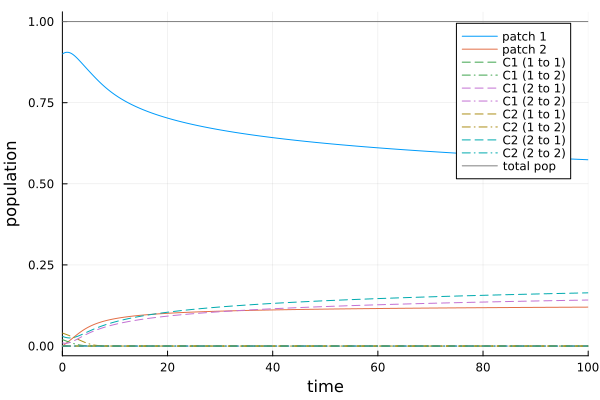

In [13]:
#########################################
# SET INITIAL CONDITIONS AND PARAMETERS #
#########################################
# Initial conditions
P_init = [0.9 0.0]
n = length(P_init)

# Construct a 2D matrix for each "layer" of the network, then concatenate,
# Every pair of distinct patches should have at least one connecting corridor
C_l1 = [0.0 0.01 ; 0.02 0.0]
C_l2 = [0.0 0.03 ; 0.04 0.0]
C_init = cat(C_l1, C_l2; dims=3)
k = size(C_init)[3]

# create a network "map" with 1's indicating the presence of a linking corridor
C_map = C_init .!= 0.0

# Make a simple matrix of β values for each "layer" of connections, then concatenate
# For now, let all corridors in a given layer have the same value of β
β1 = 60; β2 = 50 # WHY do I seemingly need to inverse my β's? Also B1=60 and B2=15 seems to give me negative P1 populations?
β_mtx = cat(C_map[:, :, 1] * β1, C_map[:, :, 2] * β2; dims=3)
# or
#β_l1 = β1 * (C_l1 .!= 0.0)
#β_l2 = β2 * (C_l2 .!= 0.0)
#β_mtx = cat(β_l1, β_l2; dims=3)

# Parameters
log_outputs = false
Δt = 100.0
α_lst = [0.7, 0.9]
p_out_lst = [1.0, 0.0] #repeat([1.0], n)
p = (α_lst, β_mtx, p_out_lst, log_outputs)
N0 = ArrayPartition(P_init, C_init)

#############################
# SOLVE SYSTEM OF EQUATIONS #
#############################
isoutofdomain = (u, p, t) -> any(x -> x < 0, u)
prob = ODEProblem(sys_of_eqs!, N0, (0.0, Δt), p)
sol = solve(prob, Vern8())#, isoutofdomain=isoutofdomain)

########
# PLOT #
########

# Plot patch populations
plt = plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
for patch_num in 2:n
    plot!(sol, idxs = (0,patch_num), xlabel="time", ylabel="population", label="patch $patch_num")
end

# Plot corridor populations
linestyles = [:dash, :dashdot, :dashdotdot, :dot] # origin patch
linecolors = palette(:default)                    # destination patch
for slice_n in 1:k
    for row_i in 1:n # loop through rows
        for col_j in 1:n # loop through columns
            sol_n = n + ((slice_n-1)*k + row_i-1)*n + col_j # but skip the first n numbers because those were patches, already plotted
            #if sol_n > 10
            #    my_col = linecolors[slice_n*k + row_i]
            #    my_ls = linestyles[col_j]
            #    println("sol_n:$sol_n -- slice_n:$slice_n, row_i:$row_i, col_j:$col_j, ls:$my_ls, color:$my_col")
            #    break
            #end
            plot!(sol, idxs = (0,sol_n), xlabel="time", ylabel="population", label="C$slice_n ($row_i to $col_j)", ls=linestyles[col_j], lc=linecolors[slice_n*k + row_i])
        end
    end
end

# plot totals
total_pop = vec(sum(sol, dims=1))
plot!(sol.t, total_pop, label="total pop", lc="gray")

display(plt)

### MARTY STOP HERE, GO NO FURTHER

### Initial conditions and parameters (3 patch case)

In [ ]:
# Initial conditions
P_init = [25.0 20.0 15.0]
n = length(P0)
# Construct a 2D matrix for each "layer" of the network, then concatenate,
# Every pair of distinct patches should have at least one connecting corridor
C_l1 = [0 5.0 5 ; 5 0 5; 5 5 0] # ones(n, n)*3
C_l2 = [0 0 5; 0 0 5; 0 0 0] # ones(n, n)*2
C_init = cat(C_l1, C_l2; dims=3)
#display(C_init)

# create a network "map" with 1's indicating the presence of a linking corridor
C_map = C_init .!= 0.0
display(C_map)

# Make a simple matrix of β values for each "layer" of connections, then concatenate
# For now, let all corridors in a given layer have the same value of β
β1 = 1/60; β2 = 1/15 # WHY do I seemingly need to inverse my β's?
β_l1 = β1 * (C_l1 .!= 0.0)
β_l2 = β2 * (C_l2 .!= 0.0)
β0 = cat(β_l1, β_l2; dims=3)
#display(β0)

# or
β_mtx = cat(C_map[:, :, 1] * β1, C_map[:, :, 2] * β2; dims=3)
#display(β_init)

# Parameters
Δt = 100.0
α_lst = repeat([1.0], n)
p_out_lst = [2.0, 1.0, 0.5] #repeat([1.0], n)
p = (α_lst, β_mtx, p_out_lst)
println(typeof(p))
N0 = ArrayPartition(P_init, C_init)

#display(N0)

## The following need to be updated to work with matrix representation of $C$ (rather than scalar representation)

### Functions to convert traffic densities to average speeds

In [ ]:
# Calculate speeds from densities
v_f = 90             # free-flow velocity, 90 km/hr, same for C1 and C2
C1_jam = 1 / β₁      # jam density for C1 (causes avg speed = 0)
C2_jam = 1 / β₂      # jam density for C2 (causes avg speed = 0)
C1_half = C1_jam / 2 # threshold density for C1 (causes avg speed = 1/2 free-flow speed)
C2_half = C2_jam / 2 # threshold density for C2 (causes avg speed = 1/2 free-flow speed)

function calc_space_mean_speed_alternative_greenshields(v_f, C, C_half; a=1)
    #=
        Returns:
            - u_s: float 
                average speed for vehicles in a given traffic flow. If negative, return 0.
        Arguments:
            - v_f: float
                free-flow velocity
            - C: float
                vehicle density (in corridor C)
            - C_half:
                threshold value of vehicle density, where u_s = 1/2 * v_f
    =#
    u_s = - (v_f / pi) * atan(a*(C - C_half)) + (v_f / 2)
    return u_s > 0 ? u_s : 0
end

### Functions to convert average speeds to emission rates

In [ ]:
# Make a U-shaped curve using data from the California paper
start = 5
my_step = 5
stop = 100
mph_to_kmh = 1.60934
speed_arr = collect(start:my_step:stop) * mph_to_kmh # convert mph to kmh
emissions_arr = [1200, 950, 700, 500, 425, 350, 325, 310, 309, 308, 308, 308, 309, 320, 330, 350, 375, 400, 450, 550] * mph_to_kmh
plot(speed_arr, emissions_arr)

# Interpolate: emissions as a function of speed
interp_fn = linear_interpolation(speed_arr, emissions_arr, extrapolation_bc=Line())

# Calculate emissions from a given array of speeds
function calc_emissions_from_speed(vehicle_pop_arr, my_speed_arr, interp_fn)
    #=
        Returns:
            - emissions: array (dim 1) 
                emission rates (g/km) for whole traffic volume (all vehicles) at each
                time step
        Arguments:
            - vehicle_pop_arr: array (dim 1) of vehicle population densities at 
              each time step
            - my_speed_arr: array (dim 1) of avg vehicle speeds at each time step
            - interp_fn: function (interpolated) relating speeds to emissions
    =#
    interpolated_emission_per_vehicle = interp_fn(my_speed_arr)
    emissions = interpolated_emission_per_vehicle .* my_speed_arr .* vehicle_pop_arr
    return emissions
end

# NOT USED - Calculate flow volume
function calc_flow(vehicle_pop_arr, v_f, k_jam)
    q = v_f .* vehicle_pop_arr - (v_f / k_jam) .* vehicle_pop_arr.^2
    return q
end

### Functions to convert emissions rates to total emissions

In [ ]:
function integrate_emissions(x, y, a, b)
    # Create an interpolation function over data points
    interp_func = LinearInterpolation(x, y, extrapolation_bc=Line())

    # Integrate the interpolated function from a to b
    result, error = quadgk(interp_func, a, b)

    return result, error
end

### Calculated expected emissions for this travel

In [ ]:
# Calculate emission rates for C1
pop_C1 = sol[3, :]
time = sol.t
C1_speeds = calc_space_mean_speed_alternative_greenshields.(v_f, pop_C1, C1_half)
C1_emissions = calc_emissions_from_speed(pop_C1, C1_speeds, interp_fn)
C1_flow = calc_flow(pop_C1, v_f, C1_jam)

# Same for C2
pop_C2 = sol[5, :]
time = sol.t
C2_speeds = calc_space_mean_speed_alternative_greenshields.(v_f, pop_C2, C2_half)
C2_emissions = calc_emissions_from_speed(pop_C2, C2_speeds, interp_fn)
C2_flow = calc_flow(pop_C2, v_f, C2_jam)

# Total emissions
C1_total_emissions = integrate_emissions(time, C1_emissions, 0.0, 100.0)[1] # [1] for value, [2] for error
formatted_C1_em = @sprintf("%.3f", C1_total_emissions)

C2_total_emissions = integrate_emissions(time, C2_emissions, 0.0, 100.0)[1]
formatted_C2_em = @sprintf("%.3f", C2_total_emissions)

Total_emissions = C1_total_emissions + C2_total_emissions
formatted_T_em = @sprintf("%.3f", Total_emissions)

C1_fraction_emissions = 100 * C1_total_emissions / Total_emissions
formatted_C1_fraction = @sprintf("%.2f", C1_fraction_emissions)

C2_fraction_emissions = 100 * C2_total_emissions / Total_emissions
formatted_C2_fraction = @sprintf("%.2f", C2_fraction_emissions)

### Old (please ignore everything from here down)
Plotting routine -- 4 patches

In [ ]:
# Plot each population over time
# Order goes down each column first (go through all the rows) and then through the columns
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="patch 3")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="patch 4")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C1 (1 to 1)", ls=:dash)
plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C1 (2 to 1)", ls=:dashdot)
plot!(sol, idxs = (0,7), xlabel="time", ylabel="population", label="C1 (3 to 1)", ls=:dashdotdot)
plot!(sol, idxs = (0,8), xlabel="time", ylabel="population", label="C1 (4 to 1)", ls=:dot)
plot!(sol, idxs = (0,9), xlabel="time", ylabel="population", label="C1 (1 to 2)", ls=:dash)
plot!(sol, idxs = (0,10), xlabel="time", ylabel="population", label="C1 (2 to 2)", ls=:dashdot)
plot!(sol, idxs = (0,11), xlabel="time", ylabel="population", label="C1 (3 to 2)", ls=:dashdotdot)
plot!(sol, idxs = (0,12), xlabel="time", ylabel="population", label="C1 (4 to 2)", ls=:dot)
plot!(sol, idxs = (0,13), xlabel="time", ylabel="population", label="C1 (1 to 3)", ls=:dash)
plot!(sol, idxs = (0,14), xlabel="time", ylabel="population", label="C1 (2 to 3)", ls=:dashdot)
plot!(sol, idxs = (0,15), xlabel="time", ylabel="population", label="C1 (3 to 3)", ls=:dashdotdot)
plot!(sol, idxs = (0,16), xlabel="time", ylabel="population", label="C1 (4 to 3)", ls=:dot)
plot!(sol, idxs = (0,17), xlabel="time", ylabel="population", label="C1 (1 to 4)", ls=:dash)
plot!(sol, idxs = (0,18), xlabel="time", ylabel="population", label="C1 (2 to 4)", ls=:dashdot)
plot!(sol, idxs = (0,19), xlabel="time", ylabel="population", label="C1 (3 to 4)", ls=:dashdotdot)
plot!(sol, idxs = (0,20), xlabel="time", ylabel="population", label="C1 (4 to 4)", ls=:dot)

#plt = plot!(sol, idxs = (0,16), xlabel="time", ylabel="population", label="C1 (3 to 4)")
#savefig(plt, "julia_plots/traffic_flows_matrix_note_β₁_$β₁" * "_β₂_$β₂" * ".png")
#display(plt)

2 patches 2D

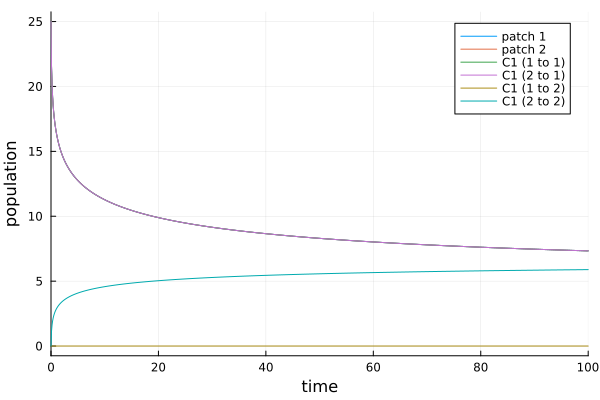

In [22]:
# Plot each population over time
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="C1 (1 to 1)")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="C1 (2 to 1)")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C1 (1 to 2)")
plt = plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C1 (2 to 2)")
#savefig(plt, "julia_plots/traffic_flows_matrix_note_β₁_$β₁" * "_β₂_$β₂" * ".png")
#display(plt)

In [124]:
sol[1:4]

retcode: Success
Interpolation: specialized 8th order lazy interpolation
t: 4-element Vector{Float64}:
 0.0
 1.5616508574188565e-5
 0.00012176761393534051
 0.0007582063023105114
u: 4-element Vector{ArrayPartition{Float64, Tuple{Matrix{Float64}, Matrix{Float64}}}}:
 ([90.0 10.0], [0.0 0.0; 0.0 0.0])
 ([89.99984386903314 9.998595503430446], [0.0 0.00015614070665769368; 0.001404486829754644 0.0])
 ([89.99878438855147 9.98910067523653], [0.0 0.0012161973939217648; 0.010898738818083304 0.0])
 ([89.99249584015409 9.933993900910021], [0.0 0.007525516118305271; 0.06598474281758454 0.0])

### Old
Would this have worked if I had finished indexing on C?

In [8]:
function traffic_flow!(dN, N, p, t)
    P¹ = N[1]      # population in patch 1
    P² = N[2]      # population in patch 2
    C¹₁₂ = N[3]    # population in corridor 1, lane from patch 1 to patch 2
    C¹₂₁ = N[4]    # population in corridor 1, lane from patch 2 to patch 1
    C²₁₂ = N[5]    # population in corridor 2, lane from patch 1 to patch 2
    C²₂₁ = N[6]    # population in corridor 2, lane from patch 2 to patch 1

    α₁ = p[1]       # tolerance for congestion, originators in patch 1
    α₂ = p[2]       # tolerance for congestion, originators in patch 2
    β₁ = p[3]       # inverse road capacity, corridor 1
    β₂ = p[4]       # inverse road capacity, corridor 2
    p1_out = p[5]   # overall demand for leaving P1
    p2_out = p[6]   # overall demand for leaving P2

    for i in 1:n
        for j in 1:n
            Fₚᶜᵏ[i,j] = [p1_out * exp(-β₁ * α₁ * Cᵏ[i,j]) * P[i]] # flux from patch i into corridor k heading in the j direction
            Fᵪₖᵖ = exp(-β₁ * Cᵏ[i,j]) * C[i,j]                    # flux from corridor k (heading from patch i to patch j) into patch j
        end
    end

    # Fluxes
    F₁ᶜ¹ = p1_out * exp(-β₁ * α₁ * C¹₁₂) * P¹   # flux from patch 1 into corridor 1 (implicitly heading towards patch 2)
    F₂ᶜ¹ = p2_out * exp(-β₁ * α₂ * C¹₂₁) * P²   # flux from patch 2 into corridor 1 (implicitly heading towards patch 1)
    F₁ᶜ² = p1_out * exp(-β₂ * α₁ * C²₁₂) * P¹   # flux from patch 1 into corridor 2 (implicitly heading towards patch 2)
    F₂ᶜ² = p2_out * exp(-β₂ * α₂ * C²₂₁) * P²   # flux from patch 2 into corridor 2 (implicitly heading towards patch 1)

    Fc₁¹ = exp(-β₁ * C¹₂₁) * C¹₂₁     # flux from corridor 1 into patch 1 (implicitly lane from p2 to p1)
    Fc₁² = exp(-β₁ * C¹₁₂) * C¹₁₂     # flux from corridor 1 into patch 2 (implicitly lane from p1 to p2)
    Fc₂¹ = exp(-β₂ * C²₂₁) * C²₂₁     # flux from corridor 2 into patch 1 (implicitly lane from p2 to p1)
    Fc₂² = exp(-β₂ * C²₁₂) * C²₁₂     # flux from corridor 2 into patch 2 (implicitly lane from p1 to p2)
    
    # Net changes to state variables
    dN[1] = Fc₁¹ + Fc₂¹ - F₁ᶜ¹ - F₁ᶜ² # change in population Patch 1
    dN[2] = Fc₁² + Fc₂² - F₂ᶜ¹ - F₂ᶜ² # change in population Patch 2
    dN[3] = F₁ᶜ¹ - Fc₁² # change in population Corridor 1 lane from p1 to p2
    dN[4] = F₂ᶜ¹ - Fc₁¹ # change in population Corridor 1 lane from p2 to p1
    dN[5] = F₁ᶜ² - Fc₂² # change in population Corridor 2 lane from p1 to p2
    dN[6] = F₂ᶜ² - Fc₂¹ # change in population Corridor 2 lane from p2 to p1
end
# Where to put conservation law??

traffic_flow! (generic function with 1 method)

In [10]:
# Choose parameters
α₁ = 1
α₂ = 1
β₁ = 10
β₂ = 60
p1_out = 1
p2_out = 0
p = [α₁, α₂, β₁, β₂, p1_out, p2_out]

P0 = [0.9, 0.1] # initial population in each patch
C0 = [0 0; 0 0] # assume max 1 corridor for each connection, and no connecting the same og and dest

# Solve diff eq
using DifferentialEquations
N0 = [1; 0.; 0; 0; 0; 0]
tspan = (0.0, 100.0)
prob = ODEProblem(traffic_flow!, N0, tspan, p)
sol = solve(prob)
using Plots
#plot(sol, idxs = (0, 1, 2))
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="C1 (1 to 2), β₁=$β₁")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C2 (1 to 2), β₂=$β₂")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="C1 (2 to 1), β₁=$β₁")
plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C2 (2 to 1), β₂=$β₂")

LoadError: UndefVarError: `Cᵏ` not defined